In [1]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt

Preproccesing Functions

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    # df_new = z_score(df_new, col_names)
    # df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    # Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df


Define the dataset

In [3]:
montage = mne.channels.make_standard_montage('standard_1020')

Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.


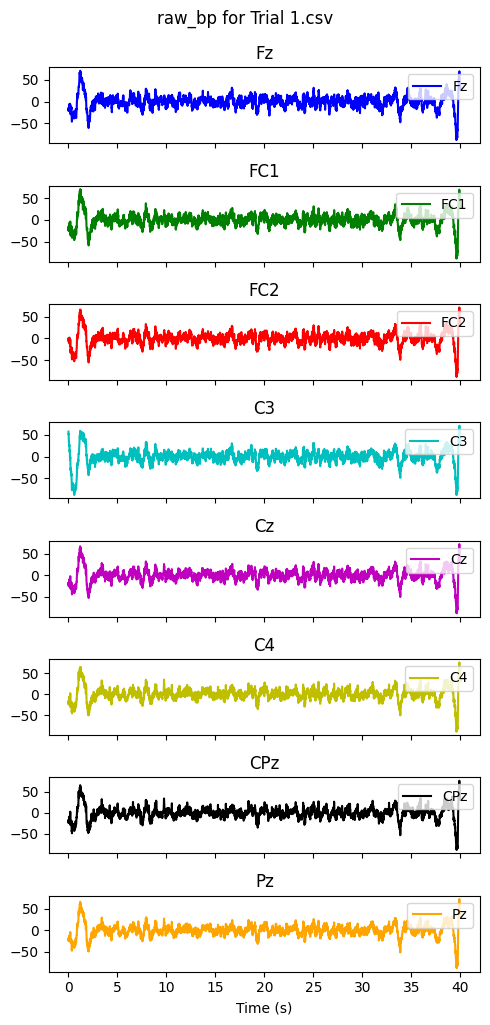

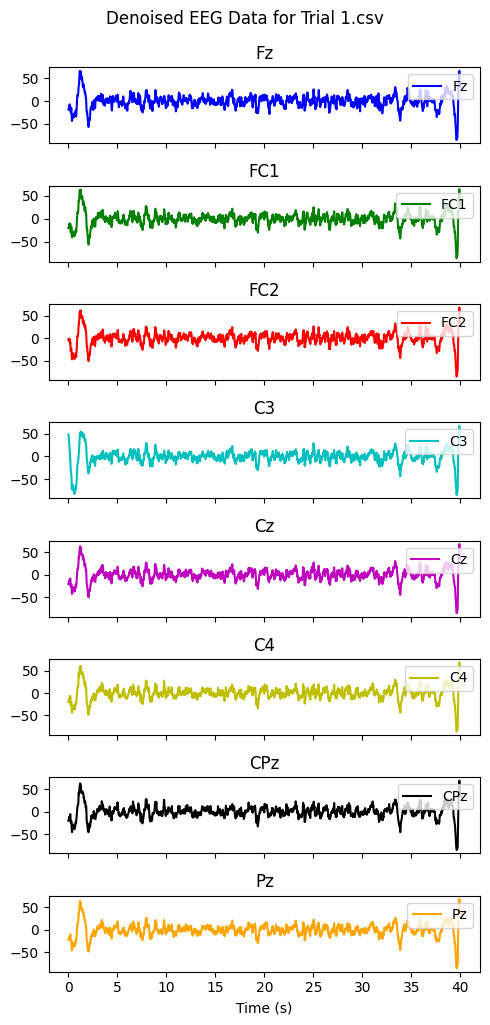

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Computing Extended Infomax ICA


C:\Users\Maryam\AppData\Local\Temp\ipykernel_29904\1566007027.py:73: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne, picks='eeg')


Fitting ICA took 1.8s.


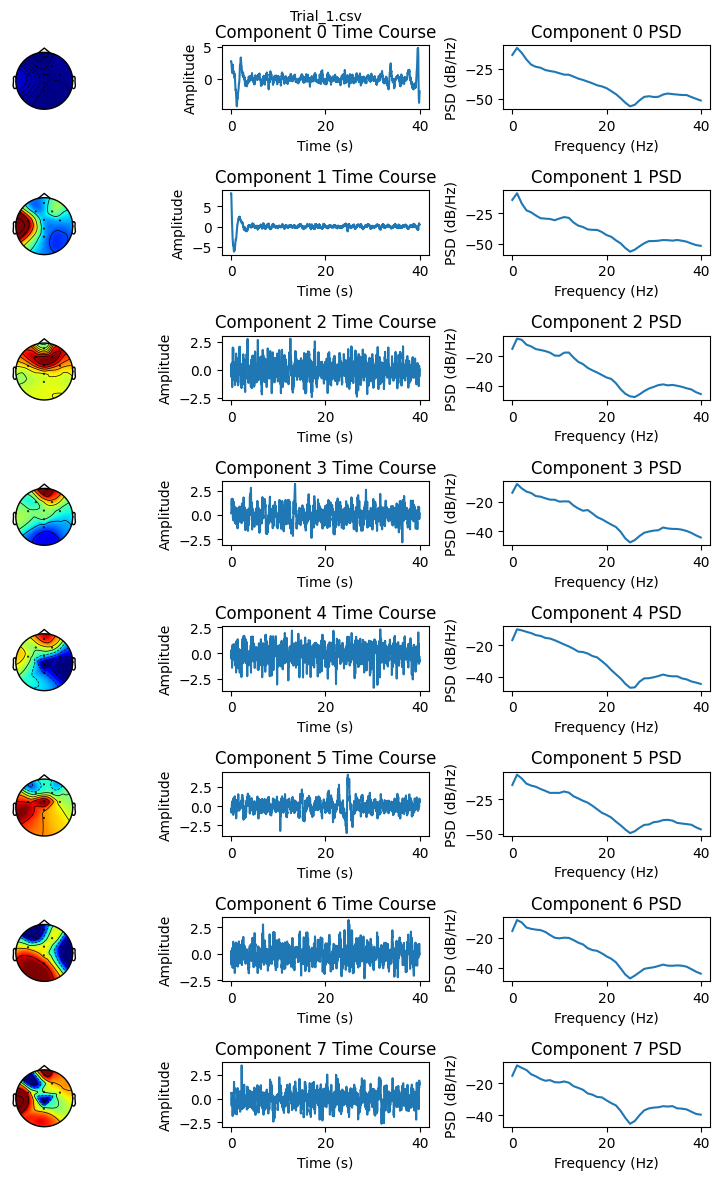

ValueError: invalid literal for int() with base 10: 'y'

In [6]:
folder_name = 'i'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
# Define a list of colors, can be extended or modified
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray']
duration = 40 
raw=[]
event=[]
PP=[]
BP=[]
dn=[]
cleaned_data_list = []
cleaned_smothed_list = []
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[:, 17]
            df_temp = s_temp.iloc[:, :8]
            # print(df_temp.shape)
            # df_temp.plot(figsize=(10, 8))
            # plt.show()
            raw.append(df_temp)
            event.append(inst)
            
            # 1. Band Pass
            raw_bp = np.copy(df_temp)
            for column in range(8):
                raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            # plt.plot(raw_bp)
            # plt.show()
            
            # Denoise the cleaned data
            raw_bp_df = pd.DataFrame(raw_bp, columns=selected_columns)
            n_clusters = [10]*len(selected_columns)  # adjust the values based on how much smoothing you want
            denoised_data_df = denoise_data(raw_bp_df, col_names=selected_columns, n_clusters=n_clusters)
            dn.append(denoised_data_df)
                        
            # 2. Create MNE Raw object
            info = mne.create_info(ch_names=selected_columns, ch_types=['eeg']*8, sfreq=250)
            raw_mne = mne.io.RawArray(denoised_data_df.T, info)
            raw_mne.set_montage(montage)
            times = raw_mne.times
            
            
            fig, axs = plt.subplots(len(selected_columns), 1, figsize=(5, 10), sharex=True)
            for i, channel in enumerate(selected_columns):
                axs[i].plot(times, raw_bp[:, i], label=channel, color=colors[i])
                axs[i].set_title(channel)
                axs[i].legend(loc="upper right")
            plt.xlabel('Time (s)')
            plt.tight_layout()
            plt.suptitle(f'raw_bp for Trial {file_name}', y=1.02)
            plt.show()
            
   
            fig, axs = plt.subplots(len(selected_columns), 1, figsize=(5, 10), sharex=True)
            for i, channel in enumerate(selected_columns):
                axs[i].plot(times, denoised_data_df[channel], label=channel, color=colors[i])
                axs[i].set_title(channel)
                axs[i].legend(loc="upper right")
            plt.xlabel('Time (s)')
            plt.tight_layout()
            plt.suptitle(f'Denoised EEG Data for Trial {file_name}', y=1.02)
            plt.show()
            
            
            satisfied_with_ica = False 
            while not satisfied_with_ica: 
            
                # 3. Apply ICA
                ica = ICA(n_components=8, method='infomax', fit_params=dict(extended=True), random_state=None, max_iter=800)
                ica.fit(raw_mne, picks='eeg')
            
                # After getting ICA sources:
                sources = ica.get_sources(raw_mne)
                source_data = sources.get_data()
                # Define the sampling frequency and parameters for the Welch method
                
                fs = 250  # Your data's sampling frequency
                nperseg = fs  # 1-second window
                noverlap = nperseg // 2  # 50% overlap

                # Create a figure to encapsulate all plots for this trial/block
                n_components = source_data.shape[0]
                fig, axes = plt.subplots(n_components, 3, figsize=(8, n_components*1.5))
                fig.suptitle(f'Trial_{file_name}', fontsize=10)

                for i in range(n_components):
                    # Topomap
                    mne.viz.plot_topomap(ica.get_components()[:, i], ica.info, axes=axes[i, 0], cmap='jet', show=False, sphere=0.08)    
                    # Time Course
                    axes[i, 1].plot(raw_mne.times, source_data[i, :])
                    axes[i, 1].set_title(f'Component {i} Time Course')
                    axes[i, 1].set_xlabel('Time (s)')
                    axes[i, 1].set_ylabel('Amplitude')
                    # PSD
                    frequencies, psd = welch(source_data[i, :], fs=fs, nperseg=nperseg)
                    mask = (frequencies >= 0) & (frequencies <= 40)
                    psd_log = 10 * np.log10(psd[mask])
                    axes[i, 2].plot(frequencies[mask], psd_log)
                    axes[i, 2].set_title(f'Component {i} PSD')
                    axes[i, 2].set_xlabel('Frequency (Hz)')
                    axes[i, 2].set_ylabel('PSD (dB/Hz)')
                plt.tight_layout()
                plt.subplots_adjust(top=0.95)
                plt.show()
                # Prompt user for components to exclude
                exclude_components_input = input("Enter components to remove as comma-separated values (e.g., 0,2,5). If none, just press Enter: ")

                if exclude_components_input.strip():  # Check if the input is not empty
                    exclude_components = [int(comp.strip()) for comp in exclude_components_input.split(",")]
                    # Mark components for exclusion
                    ica.exclude = exclude_components
                    # Apply ICA cleaning
                    raw_mne_clean = raw_mne.copy()
                    ica.apply(raw_mne_clean)
                else:
                    print("No components excluded. Proceeding with the original data.")
                    raw_mne_clean = raw_mne.copy()

                # Extract the data and times from the cleaned raw object
                clean_data = raw_mne_clean.get_data().T
                times = raw_mne_clean.times

                fig, axs = plt.subplots(len(selected_columns), 2, figsize=(10, 10), sharex=True)

                for i, channel in enumerate(selected_columns):
                    axs[i,1].plot(times, denoised_data_df[channel], label=f"{channel} (Raw)", color='gray', linestyle='--')
                    axs[i,1].plot(times, clean_data[:, i], label=f"{channel} (Cleaned)", color='b')
                    axs[i,1].legend(loc="upper right")
                    axs[i,1].set_title(channel)            
                    axs[i,0].plot(times, clean_data[:, i], label=f"{channel} (Cleaned)", color=colors[i])
                    axs[i,0].set_title(channel)
                plt.xlabel('Time (s)')
                plt.tight_layout()
                plt.suptitle(f'Cleaned vs Raw EEG Data for Trial {file_name}', y=1.02)
                plt.show()
                
                # Ask the user if they're satisfied with the applied ICA
                user_response = input("Are you satisfied with the applied ICA? (Y/N): ").strip().upper()

                if user_response == 'Y':
                    satisfied_with_ica = True  # Update satisfaction flag to exit the inner loop
                    cleaned_data_list.append(clean_data)
                    
                    # cleaned_smothed_list.append(BP_artifact_RJ_SM)
                elif user_response == 'N':
                    # Do not update the satisfaction flag, so the inner loop will restart
                    print("Reapplying ICA for the current data.")
                else:
                    print("Invalid input. Please enter 'Y' or 'N'.")
                    

            


In [14]:
print(len(cleaned_data_list), len(dn))

8 8


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming cleaned_data_list and dn are already defined

# 1. Plot each channel of each numpy array of the cleaned_data_list separately
for array_idx, cleaned_data in enumerate(cleaned_data_list):
    for channel in range(cleaned_data.shape[1]):
        plt.figure(figsize=(10, 4))
        plt.plot(cleaned_data[:, channel], label=f'Channel {channel+1}')
        plt.title(f'Cleaned Data Array {array_idx + 1} - Channel {channel+1}')
        plt.xlabel('Time Samples')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.tight_layout()
        plt.show()



In [ ]:


# 2. Plot both dn and cleaned_data in separate plots for each channel of each numpy array
for array_idx, (cleaned_data, dn_data) in enumerate(zip(cleaned_data_list, dn)):
    cleaned_data_array = np.array(cleaned_data)  # Convert DataFrame to numpy array
    dn_data_array = np.array(dn_data)  # Convert DataFrame to numpy array
    for channel in range(cleaned_data_array.shape[1]):
        plt.figure(figsize=(10, 4))
        
        # Plot cleaned data for this channel
        plt.plot(cleaned_data_array[:, channel], label=f'Cleaned Channel {channel+1}', linestyle='-')
        
        # Plot dn data for this channel
        plt.plot(dn_data_array[:, channel], label=f'dn Channel {channel+1}', linestyle='--')
        
        plt.title(f'Cleaned vs dn Data Array {array_idx + 1} - Channel {channel+1}')
        plt.xlabel('Time Samples')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [17]:
fs=250
B_N=int(len(cleaned_data_list)) #Number of blocks
PP_NP=np.array(cleaned_data_list) #shape: (B_N, 10000, 8=Channel Numbers)
event=np.array(event).reshape(B_N*(df_temp.shape[0]), 1) # df_temp.shape[0]=10000
denoised=PP_NP.reshape(B_N*(df_temp.shape[0]), 8) # seprate each blocks' signal 
pp_sig_event=np.concatenate((denoised, event), axis=1) 
labels=[] 
face = [] #lable=0
scene=[]#lable=1
# Aassuming correctness for the human behavior
for i in range(len(pp_sig_event)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels) 
                 
print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)  
#denoised is all the denoised data with shape: (df_temp.shape[0]*B_N, 8)     
# event is all the events with shape: (df_temp.shape[0]*B_N, 1)                            

event (80000, 1) denoised (80000, 8) pp_sig_event (80000, 9) face (40000, 9) scene (40000, 9) labels (80000,)


In [12]:
# fs=250
# B_N=int(len(cleaned_smothed_list)) #Number of blocks
# PP_NP=np.array(cleaned_smothed_list) #shape: (B_N, 10000, 8=Channel Numbers)
# event=np.array(event).reshape(B_N*(df_temp.shape[0]), 1) # df_temp.shape[0]=10000
# denoised=PP_NP.reshape(B_N*(df_temp.shape[0]), 8) # seprate each blocks' signal 
# pp_sig_event=np.concatenate((denoised, event), axis=1) 
# labels=[] 
# face = [] #lable=0
# scene=[]#lable=1
# # Aassuming correctness for the human behavior
# for i in range(len(pp_sig_event)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
#     if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
#         face.append(pp_sig_event[i])
#         labels.append(0)
#     else:
#         scene.append(pp_sig_event[i]) 
#         labels.append(1)        
# face = np.array(face)
# scene = np.array(scene)
# labels=np.array(labels) 
                 
# print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)  
# #denoised is all the denoised data with shape: (df_temp.shape[0]*B_N, 8)     
# # event is all the events with shape: (df_temp.shape[0]*B_N, 1)                            

event (80000, 1) denoised (80000, 8) pp_sig_event (80000, 9) face (40000, 9) scene (40000, 9) labels (80000,)


In [18]:
label=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(label[:,0])

frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40),
     }

def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal
denoised_reshaped = denoised.reshape(int(denoised.shape[0]/250), 250, 8)


In [19]:
mlp_data=denoised_reshaped.reshape(denoised_reshaped.shape[0], denoised_reshaped.shape[1]*denoised_reshaped.shape[2])
print(mlp_data.shape)

af_mlp=mlp_data
Y_mlp=np.squeeze(label[:,0])
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)
# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_mlp, y_resampled_mlp = oversampler.fit_resample(af_mlp, Y_mlp)
X_resampled_mlp= X_resampled_mlp.astype(np.float32)
y_resampled_mlp = y_resampled_mlp.astype(np.int32)


X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_resampled_mlp,y_resampled_mlp, test_size=0.1, random_state=42)


(320, 2000)
(320, 2000) (320,)


In [20]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def objective(trial):
    # Layers and neurons
    n_layers = trial.suggest_int('n_layers', 1,3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_layer{i}', 16,  512))
    
    # Activation function
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'identity'])
    
    # Learning rate
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4,  1e-1, log=True)
    
    max_iter = trial.suggest_int('max_iter', 50, 1000)

    model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                          activation=activation, 
                          learning_rate_init=learning_rate_init,
                          max_iter=max_iter ,  # to ensure convergence in most cases
                          random_state=42)

    model.fit(X_train_mlp, y_train_mlp)

    # Evaluate
    predictions = model.predict(X_test_mlp)
    accuracy = accuracy_score(y_test_mlp, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


c:\Users\Maryam\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-10-15 19:27:38,565] A new study created in memory with name: no-name-9e0118ed-91c1-4b15-a2ff-6fa69a5179a8
[I 2023-10-15 19:27:41,895] Trial 0 finished with value: 0.5 and parameters: {'n_layers': 3, 'n_units_layer0': 210, 'n_units_layer1': 440, 'n_units_layer2': 243, 'activation': 'identity', 'learning_rate_init': 0.0001477678292343837, 'max_iter': 336}. Best is trial 0 with value: 0.5.
[I 2023-10-15 19:27:48,952] Trial 1 finished with value: 0.59375 and parameters: {'n_layers': 2, 'n_units_layer0': 206, 'n_units_layer1': 307, 'activation': 'logistic', 'learning_rate_init': 0.012202911070948308, 'max_iter': 790}. Best is trial 1 with value: 0.59375.
[I 2023-10-15 19:27:49,036] Trial 2 finished with value

Number of finished trials:  70
Best trial:
  Value:  0.75
  Params: 
    n_layers: 3
    n_units_layer0: 418
    n_units_layer1: 452
    n_units_layer2: 25
    activation: logistic
    learning_rate_init: 0.0027977999481606365
    max_iter: 466


In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Extract the best parameters
best_params = study.best_params

# Extract individual parameters
n_layers = best_params['n_layers']
layers = [best_params[f'n_units_layer{i}'] for i in range(n_layers)]
activation = best_params['activation']
learning_rate_init = best_params['learning_rate_init']
max_iter = best_params['max_iter']

# Create the model using the best parameters
best_model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                           activation=activation, 
                           learning_rate_init=learning_rate_init,
                           max_iter=max_iter ,  # to ensure convergence in most cases
                           random_state=42)

# Train the model using training data
best_model.fit(X_train_mlp, y_train_mlp)

# Predict using the test data
predictions = best_model.predict(X_test_mlp)


# Predict using the training data
train_predictions = best_model.predict(X_train_mlp)

# Evaluate the model using training data
train_accuracy = accuracy_score(y_train_mlp, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")


# Evaluate the model using test data
accuracy = accuracy_score(y_test_mlp, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Training Accuracy: 0.9965
Test Accuracy: 0.7500
